# MODULES
## Execute all the imports without fail

# NOTE : All cells above which there is a * are mandatory to be executed

In [3]:
import selenium
import re
import time
from selenium import webdriver

In [4]:
import matplotlib.pyplot as plt
import networkx as nx

# To get amount from page of address *

In [5]:
def trim_amt(amt):
    amt[0]=amt[0].rstrip('&nbsp;')
    return amt

# To get address from address page
might be redundant however donot remove until updated by me

In [6]:
def trim_addr(addr,wall):
    addr=addr.replace(wall,"")
    addr=addr.lstrip("Address ")
    return addr.rstrip('\n')

# Gets all the addresses from the transaction pages *

In [7]:
def addr_list_trim(addr_list):
    new_list=[]
    for i in addr_list:
        if  re.findall(".*/address/.*",i):
            new_list.append(i)
    return new_list

# Finds number of pages for an address *

In [8]:
def trim_page_count(page_count):
    x=re.findall("/ .",page_count)
    y=re.search("\d",str(x))
    return y.group()

# Changes the number of pages into page links *

In [9]:
def get_pages(page_count,url):
    y=trim_page_count(page_count)
    page_list=[]
    if int(y)>1:
        for i in range(2,int(y)+1):
            page_list.append(str(url)+'?page='+str(i))
    return page_list

# Gets address from URL *

In [10]:
def get_addr(url):
    test_my=re.search('address/(.*)\?|address/(.*)',url)
    if test_my.group(1):
        return test_my.group(1)
    else:
        return test_my.group(2)

# Scraping logic for first page of address *

In [11]:
def scrape_addr_page1(url):
    driver.get(url)
    page_list=[]
    out=[]
    sent_tran=[]
    #out_tx=[]
    curr_addr=get_addr(url)
    amt_diff=driver.find_elements_by_xpath('//tr/td[@class="amount diff"]')
    txid=driver.find_elements_by_xpath('//tr/td[@class="txid"]/a[@href]')
    #bal=driver.find_element_by_xpath('//tr/td[@class="amount"]')
    #bal=bal.get_attribute('innerHTML').rstrip('&nbsp;')
    #curr_addr=re.search('address/(.*)\?',url)
    #curr_addr=driver.find_element_by_xpath('//body/div[@id="main"]/h2').text
    #curr_wall=driver.find_element_by_xpath('//body/div[@id="main"]/h2/div').text
    #curr_addr=trim_addr(curr_addr,curr_wall)
    for (x,y) in zip(amt_diff,txid):
        if x.get_attribute('innerHTML')[0]=='-':
            sent_tran.append(y.get_attribute('href'))
        out.append([x.get_attribute('innerHTML'),curr_addr,y.get_attribute('href')])
    out=list(map(trim_amt,out))
    page_count=driver.find_element_by_xpath("//div[@class='paging']").text
    page_list=get_pages(page_count,url)
    return out,sent_tran,page_list

# Scraping logic for succsesive pages of address *

In [12]:
def scrape_addr_other(url):
    driver.get(url)
    #page_list=[]
    out=[]
    curr_addr=get_addr(url)
    #out_tx=[]
    sent_tran=set()
    amt_diff=driver.find_elements_by_xpath('//tr/td[@class="amount diff"]')
    txid=driver.find_elements_by_xpath('//tr/td[@class="txid"]/a[@href]')
    #curr_addr=driver.find_element_by_xpath('//body/div[@id="main"]/h2').text
    #curr_wall=driver.find_element_by_xpath('//body/div[@id="main"]/h2/div').text
    #curr_addr=trim_addr(curr_addr,curr_wall)
    for (x,y) in zip(amt_diff,txid):
        if x.get_attribute('innerHTML')[0]=='-':
            sent_tran.add(y.get_attribute('href'))
        out.append([x.get_attribute('innerHTML'),curr_addr,y.get_attribute('href')])
        #s_or_r[y.get_attribute('href')]=x.get_attribute('innerHTML')[0]
    out=list(map(trim_amt,out))
    return out,sent_tran

# Scraping logic for transaction pages *

In [13]:
def scrape_txid(url):
    driver.get(url)
    new_addr=driver.find_elements_by_xpath('//table[@class="empty"]/tbody/tr/td/a[@href]')
    x=driver.find_elements_by_xpath('//table[@class="tx"]/tbody/tr/th/b')
    ip=re.search(' \d+ ',x[0].get_attribute('innerHTML')).group()
    op=re.search(' \d+ ',x[0].get_attribute('innerHTML')).group()
    ip_addr_list=[]
    op_addr_list=[]
    ip_addr_set=set()
    op_addr_set=set()
    i=0
    #print('inputs',ip)
    for addr in new_addr:
        #print('value of i',i)
        if 'address' in addr.get_attribute("href"):
            if i<int(ip):
                ip_addr_list.append(addr.get_attribute("href"))
                ip_addr_set.add(re.search('address/(.*)',addr.get_attribute("href")).group(1))
                #ip_addr_list=addr_list_trim(ip_addr_list)
            else:
                op_addr_list.append(addr.get_attribute("href"))
                op_addr_set.add(re.search('address/(.*)',addr.get_attribute("href")).group(1))
                #op_addr_list=addr_list_trim(op_addr_list)
            #addr_set.add(re.search('address/(.*)',addr.get_attribute("href")).group(1))
            i+=1
    return ip_addr_list,op_addr_list,ip_addr_set,op_addr_set

# Decision function to decide the typr of scraper to use *

In [14]:
def decision_func(url): 
    test_url=re.search('address/(.*)\?|address/(.*)|txid/(.*)',url)
    if test_url.group(1):
        #print('Gone to other')
        res,sent_tran=scrape_addr_other(url)
        return res,sent_tran
    elif test_url.group(2):
        #print('Gone to one')
        res,sent_tran,res_page=scrape_addr_page1(url)
        return res,sent_tran,res_page
    elif test_url.group(3):
        ip_res,op_res,dis_add_ip,dis_add_op=scrape_txid(url)
        return ip_res,op_res,dis_add_ip,dis_add_op
    else:
        print("Wrong")

# Used to get addresses from list of address links
Again might be redundant, run only if error occurs

In [15]:
def get_add_from_list(addr_list):
    new_list=[]
    for i in addr_list:
        x=re.search('address/(.*)',i)
        new_list.append(x.group(1))
    return new_list

# Address Node Class *
#### Each address node has balance, list of nodes it has sent bitcoins to and its address as attributes  
#### The constructor needs the address of the node to be created to work  
#### get_bal: gets balance for the address  
#### set_sent_urls: sets sent_urls attribute, ie transactions in which it has acted as input  
#### set_sent: sets sent_to attribute, ie list of addresses the address has sent bitcoin/s to

In [16]:
class addressNode:
    def getbal(self,url):
        time.sleep(10)
        trans=[]
        driver.get(url)
        bal=driver.find_element_by_xpath('//tr/td[@class="amount"]')
        txids=driver.find_elements_by_xpath('//tr/td[@class="txid"]/a[@href]')
        for x in txids:
            trans.append(x.get_attribute('href'))
        return bal.get_attribute('innerHTML').rstrip('&nbsp;'),trans
    def __init__(self,address):
        self.sent_to=[]
        self.sent_urls=set()
        #self.s_or_r=dict()
        print('ADDRESS CREATED : https://www.walletexplorer.com/address/'+address)
        self.bal,self.trans=self.getbal('https://www.walletexplorer.com/address/'+address)
        #self.recieved_from=[]
        self.addr=address
    #def set_recieved(self,sending_address):
        #self.recieved_from.append(sending_address)
    def set_sent_urls(self,send_tran):
        self.sent_urls=self.sent_urls.union(send_tran)
    def set_sent(self,rec_address):
        self.sent_to=self.sent_to+rec_address

# Edge Class *
#### A simple class which stores two address node objects, sender and reciever

In [17]:
class Edge:
    def __init__(self,sender,reciever):
        self.sender=sender
        self.reciever=reciever

# Driver to start webdriver
##### ie a bot window of firefox

In [18]:
driver=webdriver.Firefox()

# DEPRECATED 
## Maybe run for testing purposes

In [215]:
sent_to=[]
addresses=dict()
url='https://www.walletexplorer.com/address/12h8BbuTYYC6zWpTNfbYoGv4LpVGv38MUx'
#url='https://www.walletexplorer.com/address/1Nnj7nQY3RJi8c8yufTfwZUhDYLL8z762G'
#url='https://www.walletexplorer.com/txid/d467427a909f9f5e70482ca8ff9a3b15342e5073578753583df74edcc6a8724a'
#for i in range(2):
all_links=[]
for i in range(5):
    print('URL IS:',str(url))
    output=decision_func(url)
    #if i==1:
        #print(output[0])
    #print(re.search('address/(.*)',url).group(1))
    #print(output[0])
    #print(output[1])
    #print(output[2])
    #if 'address' in url:
    #if i==1:
        #print(output)
    #curr_add=re.search('address/(.*)',url).group(1)
    #if 'address' in url and '?page=' not in url:
        #if curr_add not in addresses:
            #addresses[curr_add]=addressNode(curr_add)
            #addresses[curr_add].set_sent_urls(output[1])
        #a#ddresses[curr_add].set_sent_urls(output[1])
    #if 'address' in url:
        #addresses[curr_add].set_sent_urls(output[1])
    #else:
    if 'txid' in url: 
        for x in output[2]:
            addresses[x]=addressNode(x)
            addresses[x].set_sent(list(output[3]))
            all_links=all_links+addresses[x].trans
        for x in output[3]:
            addresses[x]=addressNode(x)
            all_links=all_links+addresses[x].trans
    if 'address' in url and len(output)==3 and len(output[2])!=0:
        #print('First and more pages')
        all_links=all_links+output[2]
        all_links=all_links+list(map((lambda l : l[2]),output[0]))
    elif 'address' in url and len(output)==3 and len(output[2])==0:
        #print('First and only page')
        all_links=all_links+list(map((lambda l : l[2]),output[0]))
    elif 'address' in url and len(output)==2:
        #print('Not first page')
        all_links=all_links+list(map((lambda l : l[2]),output[0]))
    #else:
        #all_links=all_links+output[0]
        #all_links=all_links+output[1]
    #print(all_links)
    url=all_links.pop(0)
#print(addresses[].sent_urls)
#print(addresses[len(addresses)-1].sent_to)
    print("next url : ",url)
    time.sleep(10)
#print(addresses)
for i in addresses:
    print(i,' : ',addresses[i].bal)
    print(addresses[i].sent_to)

URL IS: https://www.walletexplorer.com/address/12h8BbuTYYC6zWpTNfbYoGv4LpVGv38MUx
next url :  https://www.walletexplorer.com/txid/3b76f5acc3f6231b95e141503b4a00df2110172951d3e631c2f2c234bb2e6ce1
URL IS: https://www.walletexplorer.com/txid/3b76f5acc3f6231b95e141503b4a00df2110172951d3e631c2f2c234bb2e6ce1
URLS ARE : https://www.walletexplorer.com/address/bc1qy56w85eevv3fgxqaxju7g28krc24uswuxg32yw
URLS ARE : https://www.walletexplorer.com/address/12h8BbuTYYC6zWpTNfbYoGv4LpVGv38MUx
URLS ARE : https://www.walletexplorer.com/address/bc1qw5dyyaeaws4pn0jyau4yw4xq98n4caqvmwyvse
next url :  https://www.walletexplorer.com/txid/3b70b7ef8af58563c7a2c69b2179b9cec2aa3d4f33d0a18d0779a67fe2d23673
URL IS: https://www.walletexplorer.com/txid/3b70b7ef8af58563c7a2c69b2179b9cec2aa3d4f33d0a18d0779a67fe2d23673
URLS ARE : https://www.walletexplorer.com/address/bc1qcf26j5kk2r5lx04n7m0wmeeeq8j5zqx3rsmddn
URLS ARE : https://www.walletexplorer.com/address/12h8BbuTYYC6zWpTNfbYoGv4LpVGv38MUx
URLS ARE : https://www.wa

# DEPRECATED 
## May be run for testing purposes

In [216]:
edges=[]
for i in addresses:
    for j in addresses[i].sent_to:
        edges.append(Edge(addresses[i],addresses[j]))
for x in edges:
    print(x.sender.addr+' : '+x.reciever.addr)

bc1qy56w85eevv3fgxqaxju7g28krc24uswuxg32yw : 12h8BbuTYYC6zWpTNfbYoGv4LpVGv38MUx
bc1qy56w85eevv3fgxqaxju7g28krc24uswuxg32yw : bc1qw5dyyaeaws4pn0jyau4yw4xq98n4caqvmwyvse
12h8BbuTYYC6zWpTNfbYoGv4LpVGv38MUx : 15FmAQrgCYyGGMghwGy6ChWavXv7PrVDGS
bc1qcf26j5kk2r5lx04n7m0wmeeeq8j5zqx3rsmddn : 12h8BbuTYYC6zWpTNfbYoGv4LpVGv38MUx
bc1qcf26j5kk2r5lx04n7m0wmeeeq8j5zqx3rsmddn : bc1qpwc3ptnekcvns3994gy3vkzfr9hm0tt9ce5v6c
1GhmnT8TsKY7QAwoA4AGwten2giMcVpNq6 : 12h8BbuTYYC6zWpTNfbYoGv4LpVGv38MUx
1GhmnT8TsKY7QAwoA4AGwten2giMcVpNq6 : 1EfVwJvUDtoDHV9krfXofvSTrqUkMwvB5m
1Nnj7nQY3RJi8c8yufTfwZUhDYLL8z762G : 15FmAQrgCYyGGMghwGy6ChWavXv7PrVDGS
1NdMFXKKbSqSpfT4rbssTDpymuCRAoCme2 : 15FmAQrgCYyGGMghwGy6ChWavXv7PrVDGS
14SqpxJWnJ42qXcATpV2LxBPozuQe15XM9 : 15FmAQrgCYyGGMghwGy6ChWavXv7PrVDGS
17tcnYLMBtyUi1vYPjc7V9kwcfc8rsFDrh : 15FmAQrgCYyGGMghwGy6ChWavXv7PrVDGS
13kyU2HQSi2mt1rzCEWf2hZrbx9puWzh9i : 15FmAQrgCYyGGMghwGy6ChWavXv7PrVDGS
14AF5b75EnLC5bdhmSQNA2kdcw3Xrdq2ST : 15FmAQrgCYyGGMghwGy6ChWavXv7PrVDGS
1AckdtCPnmFZ5bRG

# A GRAPH CLASS USED TO CREATE GRAPH OBJECT FOR NETWORKX *

In [19]:
class Graph:
    def __init__(self):
        self.visual=[]
    def addEdge(self,edge):
        self.visual.append(edge)
    def visualize(self):
        #plt.figure(1,figsize(32,32))
        plt.figure(figsize=(20,20))
        G=nx.Graph()
        G.add_edges_from(self.visual)
        nx.draw_networkx(G)
        plt.show()

# DEPRECATED 
## Maybe run for testing purposes

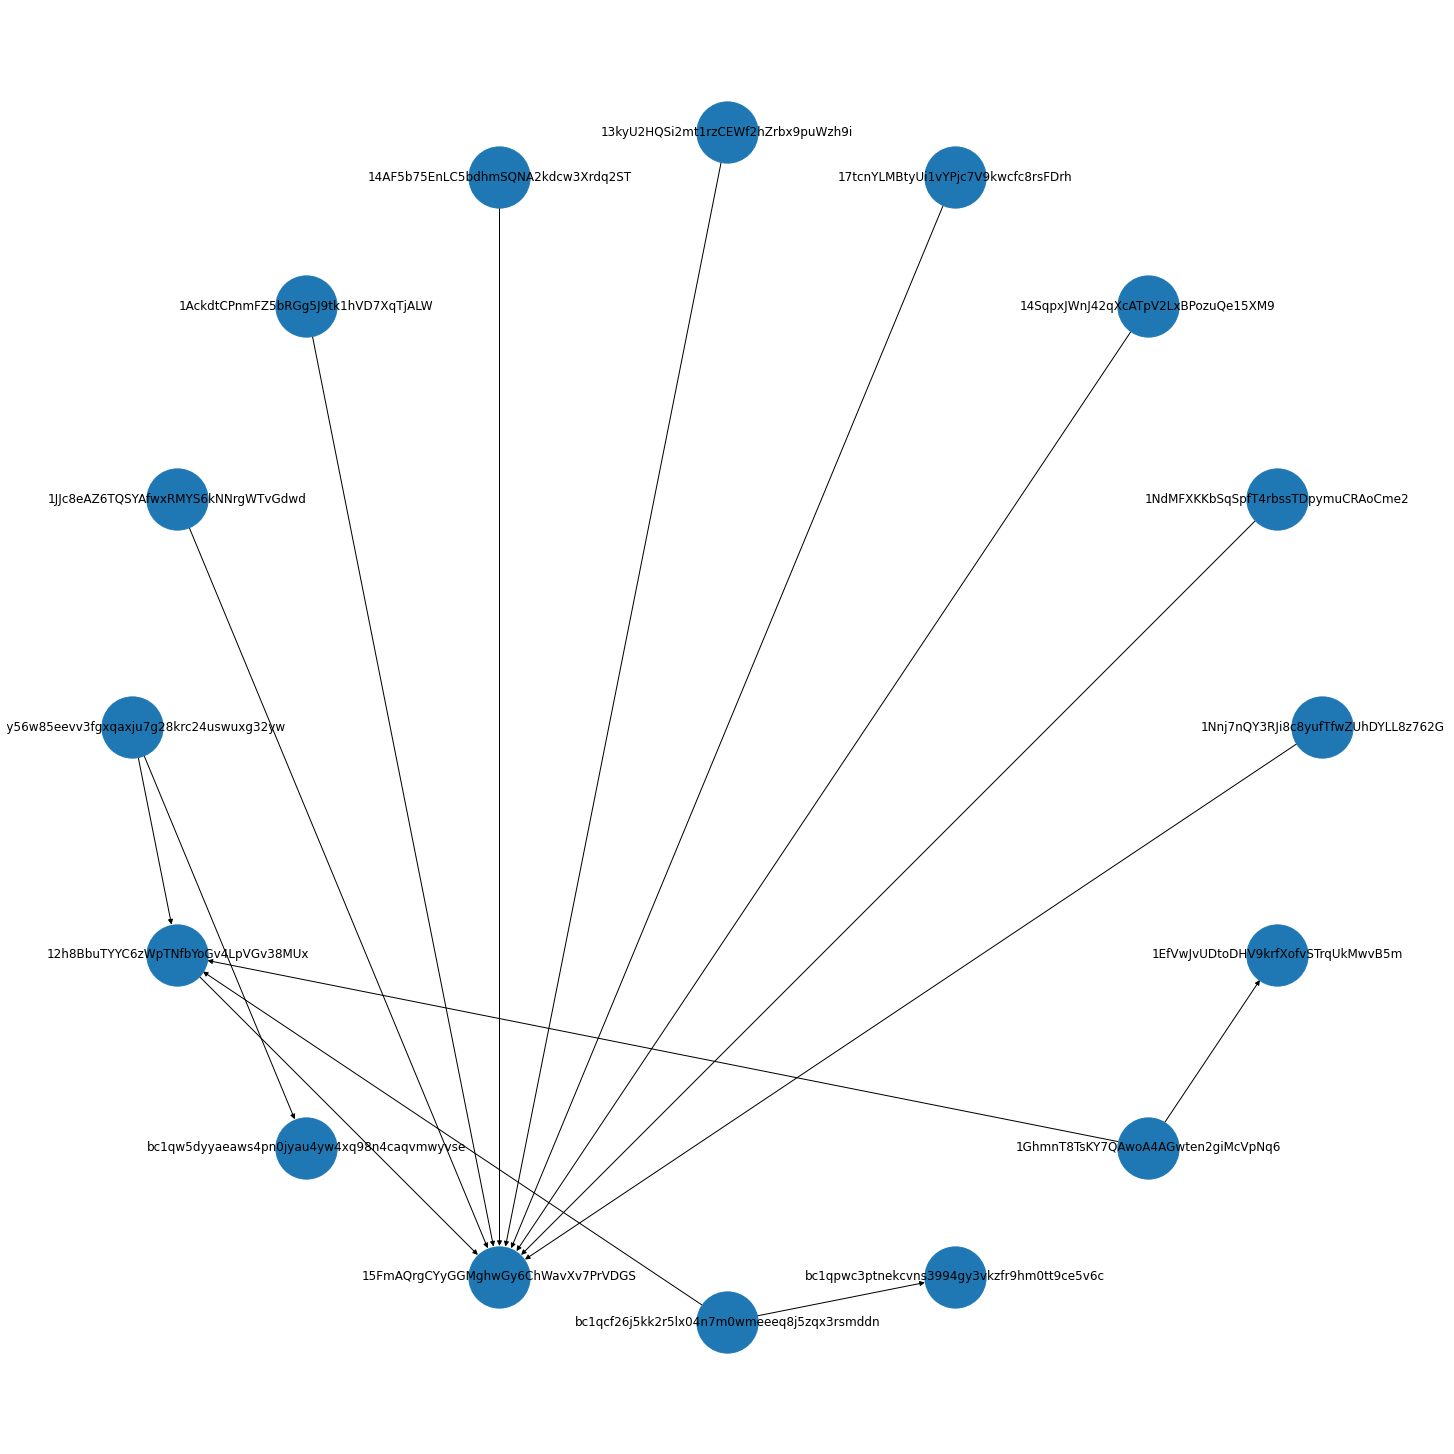

In [218]:
G=nx.DiGraph()
temp=[]
for x in edges:
    temp.append([x.sender.addr,x.reciever.addr])
    
G.add_edges_from(temp)
plt.figure(figsize=(20,20))
nx.draw_shell(G,node_size=3750,with_labels=True)

# Crawl time function *
### This is an overlapping function, mostly with the crawler running logic, ie implements the crawler, ie changes the scrapers into a crawler 

In [24]:
def crawl_time(url,all_links=[],addresses=dict()):
    #driver=webdriver.Firefox()
    try:
        #flag=True
        #i=1
        for i in range(5):
            flag=False
            '''if i%3==0:
                driver.close()
                driver=webdriver.Firefox()
                i=1'''
            print('URL IS:',str(url))
            output=decision_func(url)
            #if i==1:
                #print(output[0])
            #print(re.search('address/(.*)',url).group(1))
            #print(output[0])
            #print(output[1])
            #print(output[2])
            #if 'address' in url:
            #if i==1:
                #print(output)
            #curr_add=re.search('address/(.*)',url).group(1)
            '''if 'address' in url and '?page=' not in url:
                if curr_add not in addresses:
                    addresses[curr_add]=addressNode(curr_add)
                    addresses[curr_add].set_sent_urls(output[1])
                addresses[curr_add].set_sent_urls(output[1])'''
            #if 'address' in url:
                #addresses[curr_add].set_sent_urls(output[1])
            #else:
            if 'txid' in url: 
                for x in output[2]:
                    if x not in addresses:
                        addresses[x]=addressNode(x)
                        addresses[x].set_sent(list(output[3]))
                        all_links=all_links+addresses[x].trans
                for x in output[3]:
                    if x not in addresses:
                        addresses[x]=addressNode(x)
                        all_links=all_links+addresses[x].trans
            if 'address' in url and len(output)==3 and len(output[2])!=0:
                #print('First and more pages')
                all_links=all_links+output[2]
                all_links=all_links+list(map((lambda l : l[2]),output[0]))
            elif 'address' in url and len(output)==3 and len(output[2])==0:
                #print('First and only page')
                all_links=all_links+list(map((lambda l : l[2]),output[0]))
            elif 'address' in url and len(output)==2:
                #print('Not first page')
                all_links=all_links+list(map((lambda l : l[2]),output[0]))
            #else:
                #all_links=all_links+output[0]
                #all_links=all_links+output[1]
            #print(all_links)
            url=all_links.pop(0)
    #print(addresses[].sent_urls)
    #print(addresses[len(addresses)-1].sent_to)
            print("next url : ",url)
            print(addresses)
        time.sleep(10)
        #eg_run=True
        return addresses ,all_links
    except:
        #eg_run=False
        return addresses,all_links

# WEB DRIVER CALL
### Note: Run only one web driver call, ie the one above or this one. DO NOT run both

In [70]:
driver=webdriver.Firefox()

# TEST CELL
No need to run

In [165]:
res_addr=crawl_time('https://www.walletexplorer.com/address/12h8BbuTYYC6zWpTNfbYoGv4LpVGv38MUx')
'''for i in addresses:
        print(i,' : ',addresses[i].bal)
        print(addresses[i].sent_to)'''

URL IS: https://www.walletexplorer.com/address/12h8BbuTYYC6zWpTNfbYoGv4LpVGv38MUx
next url :  https://www.walletexplorer.com/txid/4094512c86730201b8672d6dd3a0dbc32d1c3d1ad8174adb2dd703e77877deb5
URL IS: https://www.walletexplorer.com/txid/4094512c86730201b8672d6dd3a0dbc32d1c3d1ad8174adb2dd703e77877deb5
ADDRESS CREATED : https://www.walletexplorer.com/address/12h8BbuTYYC6zWpTNfbYoGv4LpVGv38MUx
ADDRESS CREATED : https://www.walletexplorer.com/address/19CuHw6LXPwJotMBd2zEKHPtzbxLQHNkja
ADDRESS CREATED : https://www.walletexplorer.com/address/16yAihkWzK3HVQozvNN2Wk3BfzhXTU6mew
ADDRESS CREATED : https://www.walletexplorer.com/address/14xCqH658JEZ5uNHbhqc3xLaWPYW8bBP4W
ADDRESS CREATED : https://www.walletexplorer.com/address/1JRsRo97qPoU8hezbrgCPaz8wwoDWhFp1a
ADDRESS CREATED : https://www.walletexplorer.com/address/1Nnj7nQY3RJi8c8yufTfwZUhDYLL8z762G
ADDRESS CREATED : https://www.walletexplorer.com/address/1M7zVSBVVDpEG48xQz1XMk9RmyHMitoesu
ADDRESS CREATED : https://www.walletexplorer.com/add

"for i in addresses:\n        print(i,' : ',addresses[i].bal)\n        print(addresses[i].sent_to)"

In [166]:
addresses,links=res_addr
for i in addresses:
        print(i,' : ',addresses[i].bal)
        print(addresses[i].sent_to)

12h8BbuTYYC6zWpTNfbYoGv4LpVGv38MUx  :  0.
['1D9Qd82uFdKMHagHkhq3jJGJjmzA8Tifx3']
19CuHw6LXPwJotMBd2zEKHPtzbxLQHNkja  :  0.
['1D9Qd82uFdKMHagHkhq3jJGJjmzA8Tifx3']
16yAihkWzK3HVQozvNN2Wk3BfzhXTU6mew  :  0.
['1D9Qd82uFdKMHagHkhq3jJGJjmzA8Tifx3']
14xCqH658JEZ5uNHbhqc3xLaWPYW8bBP4W  :  0.
['1D9Qd82uFdKMHagHkhq3jJGJjmzA8Tifx3']
1JRsRo97qPoU8hezbrgCPaz8wwoDWhFp1a  :  0.
['1D9Qd82uFdKMHagHkhq3jJGJjmzA8Tifx3']
1Nnj7nQY3RJi8c8yufTfwZUhDYLL8z762G  :  0.
['1D9Qd82uFdKMHagHkhq3jJGJjmzA8Tifx3']
1M7zVSBVVDpEG48xQz1XMk9RmyHMitoesu  :  0.
['1D9Qd82uFdKMHagHkhq3jJGJjmzA8Tifx3']
1D9Qd82uFdKMHagHkhq3jJGJjmzA8Tifx3  :  0.
[]
bc1qy56w85eevv3fgxqaxju7g28krc24uswuxg32yw  :  0.
['12h8BbuTYYC6zWpTNfbYoGv4LpVGv38MUx', 'bc1qw5dyyaeaws4pn0jyau4yw4xq98n4caqvmwyvse']
bc1qw5dyyaeaws4pn0jyau4yw4xq98n4caqvmwyvse  :  0.
[]
bc1qcf26j5kk2r5lx04n7m0wmeeeq8j5zqx3rsmddn  :  0.
['12h8BbuTYYC6zWpTNfbYoGv4LpVGv38MUx', 'bc1qpwc3ptnekcvns3994gy3vkzfr9hm0tt9ce5v6c']
bc1qpwc3ptnekcvns3994gy3vkzfr9hm0tt9ce5v6c  :  0.007181
[]
1GhmnT

# Create graph function (Run only after getting something in the addresses)
#### A function to create graph from dictionary of address objects obtained after crawling

In [21]:
def create_graph(addresses):
    edges=[]
    for i in addresses:
        for j in addresses[i].sent_to:
            edges.append(Edge(addresses[i],addresses[j]))
    #for x in edges:
    G=nx.DiGraph()
    temp=[]
    for x in edges:
        temp.append([x.sender.addr,x.reciever.addr])
    G.add_edges_from(temp)
    plt.figure(figsize=(20,20))
    nx.draw_shell(G,node_size=3750,with_labels=True)
    return edges,G

# TEST

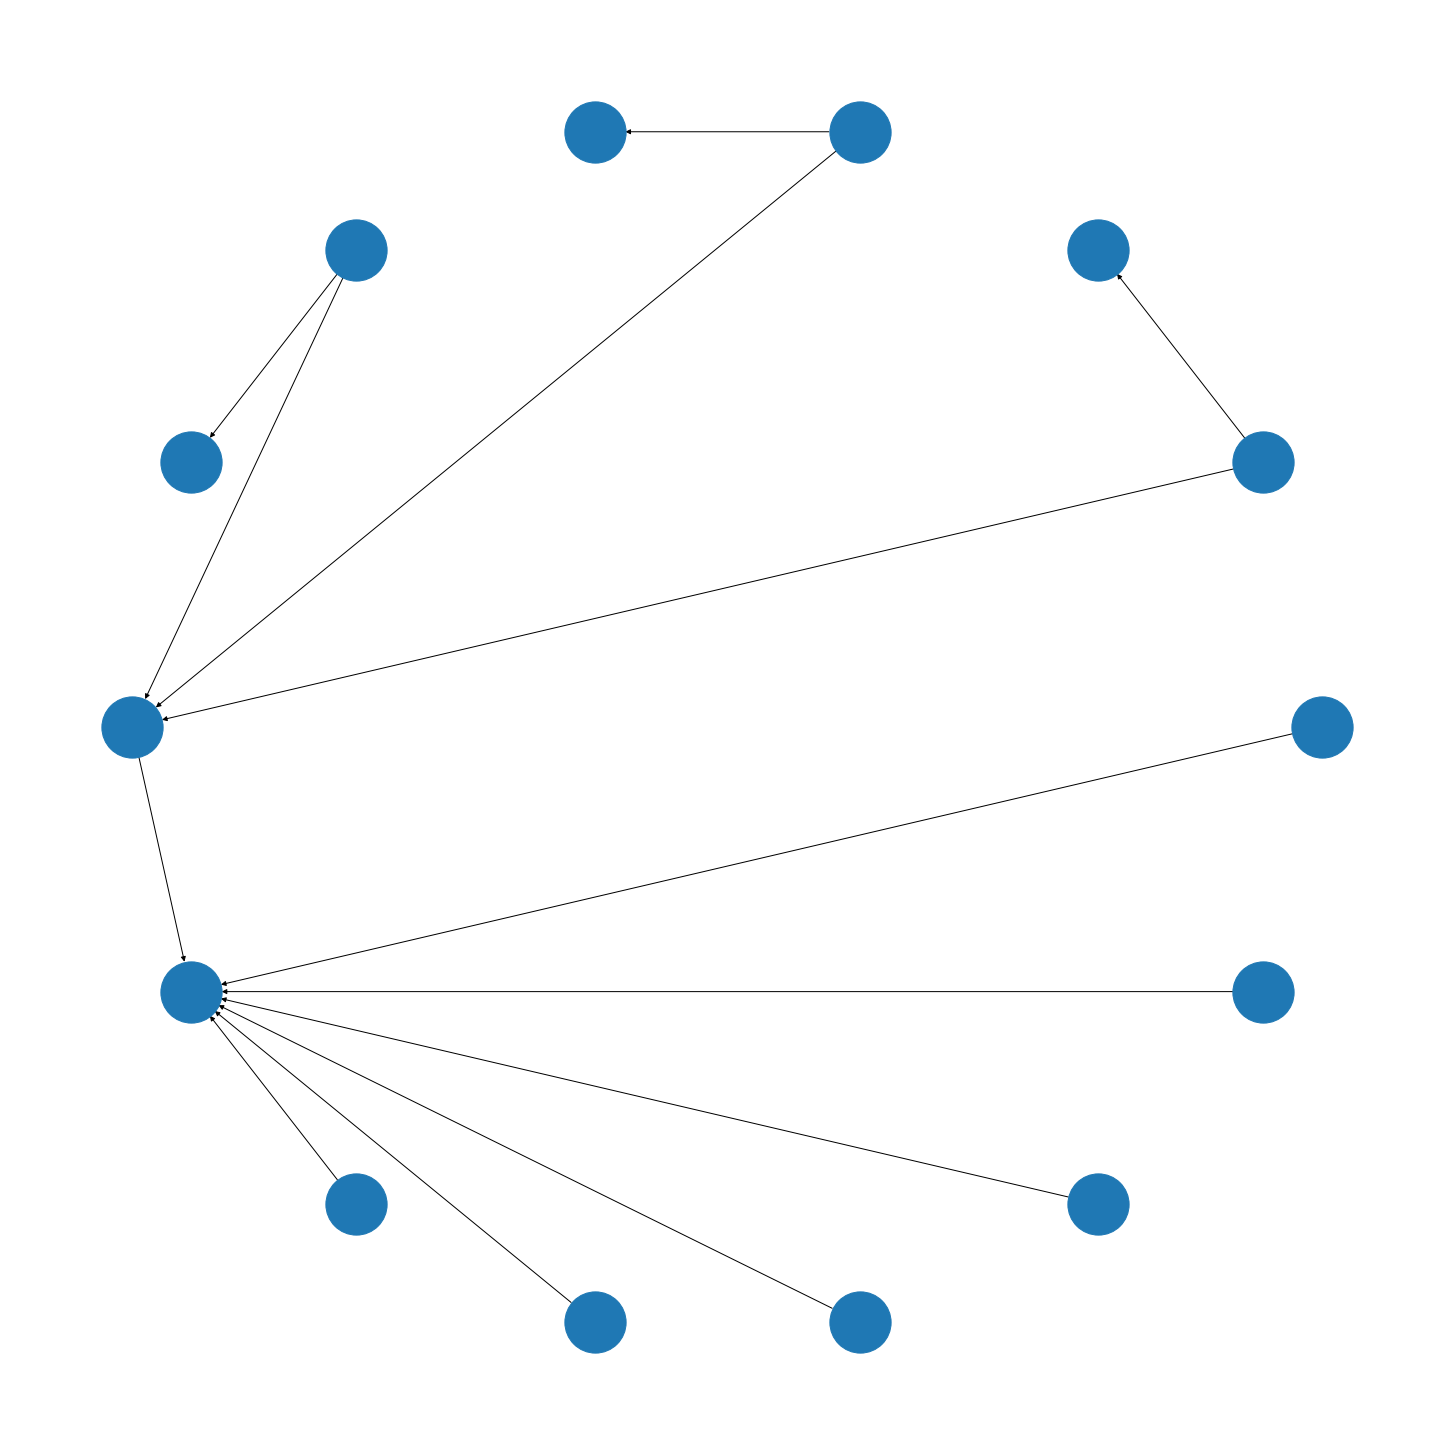

In [167]:
res_edges,nx_graph=create_graph(addresses)

# AIO CRAWL FUNCTION
## A function to introduce a level of abstraction. User level function 
### Might be provided with:     
#### url : URL of address/transaction to be scraped. If previously crawling has been done, provide the first link from all links as url and pop it from all_links  
#### all_links : list of links to be crawled if previously crawling has been done  
#### addresses: dict of addresses if crawling has been donw previously

In [37]:
def aio_crawl(url,all_links=[],addresses=dict()):
    returned_addresses,returned_links=crawl_time(url,all_links,addresses)
    print('Check:',returned_addresses)
    #print(returned_links)
    #print(reg_run)
    addresses=returned_addresses
    '''while returned_links:
        #print('In loop')
        #print(reg_run)
        print(addresses)
        returned_addresses,returned_links=crawl_time(url,all_links,addresses)
        addresses=addresses.update(returned_addresses)'''
    print('Out:',addresses)
    for i in range(5):
        print('A:',addresses)
        url=returned_links.pop(0)
        returned_addresses,returned_links=crawl_time(url,all_links,addresses)
        addresses=addresses.update(returned_addresses)
    return addresses,returned_links

# Highest level abstraction call

In [38]:
ret_addr,links_left=aio_crawl('https://www.walletexplorer.com/address/12h8BbuTYYC6zWpTNfbYoGv4LpVGv38MUx')
edges,G=create_graph(ret_addr)

URL IS: https://www.walletexplorer.com/address/12h8BbuTYYC6zWpTNfbYoGv4LpVGv38MUx
next url :  https://www.walletexplorer.com/txid/4094512c86730201b8672d6dd3a0dbc32d1c3d1ad8174adb2dd703e77877deb5
{}
URL IS: https://www.walletexplorer.com/txid/4094512c86730201b8672d6dd3a0dbc32d1c3d1ad8174adb2dd703e77877deb5
ADDRESS CREATED : https://www.walletexplorer.com/address/1JRsRo97qPoU8hezbrgCPaz8wwoDWhFp1a
ADDRESS CREATED : https://www.walletexplorer.com/address/1M7zVSBVVDpEG48xQz1XMk9RmyHMitoesu
ADDRESS CREATED : https://www.walletexplorer.com/address/14xCqH658JEZ5uNHbhqc3xLaWPYW8bBP4W
ADDRESS CREATED : https://www.walletexplorer.com/address/12h8BbuTYYC6zWpTNfbYoGv4LpVGv38MUx
ADDRESS CREATED : https://www.walletexplorer.com/address/1Nnj7nQY3RJi8c8yufTfwZUhDYLL8z762G
ADDRESS CREATED : https://www.walletexplorer.com/address/19CuHw6LXPwJotMBd2zEKHPtzbxLQHNkja
ADDRESS CREATED : https://www.walletexplorer.com/address/16yAihkWzK3HVQozvNN2Wk3BfzhXTU6mew
ADDRESS CREATED : https://www.walletexplorer.com/

ADDRESS CREATED : https://www.walletexplorer.com/address/bc1q5f0dct67l564c85crsq9hdqtahkkun2tsm4nne
ADDRESS CREATED : https://www.walletexplorer.com/address/1NDyJtNTjmwk5xPNhjgAMu4HDHigtobu1s
ADDRESS CREATED : https://www.walletexplorer.com/address/3EePhyt8EwQUs5tJqMasGKaGJyDSPhdEmA
ADDRESS CREATED : https://www.walletexplorer.com/address/31uAFV7C7cuxfajcfTPUGeCEHUV6PaFSg4
ADDRESS CREATED : https://www.walletexplorer.com/address/1KNH3mt3VfSVkYES2JskjoA2Y54DDDk7TC
ADDRESS CREATED : https://www.walletexplorer.com/address/1MCxoAyFeQoghzXNe3hmFPXSr5amTZsqyN
ADDRESS CREATED : https://www.walletexplorer.com/address/13hiipZaFgQy8R8T3Cf774qvzkzMgmNMip
ADDRESS CREATED : https://www.walletexplorer.com/address/bc1qeusxfktltt8lvw80267wr9jn34x5wl57c3wvzx
ADDRESS CREATED : https://www.walletexplorer.com/address/1CcmdobqbWdCfghnpadvPmB4NsSSdLM8vd
ADDRESS CREATED : https://www.walletexplorer.com/address/38q6ifrkNDRz8nBUUErxXJtzrWQj9XKJTA
ADDRESS CREATED : https://www.walletexplorer.com/address/37zBJAz

ADDRESS CREATED : https://www.walletexplorer.com/address/37Db6mYKFM5gUxsSzEQPb2WbubYehJTEQR
ADDRESS CREATED : https://www.walletexplorer.com/address/3BhGSaEQWogRJjUR64hwQeohGbBX4nMbTY
ADDRESS CREATED : https://www.walletexplorer.com/address/1ASaSBpsYhrs4R4kdcGhVpd3H6UD1JU6yf
ADDRESS CREATED : https://www.walletexplorer.com/address/3DXAu4sVW9hbZQ5zKbdgm1y3uwjQ9DqgZA
ADDRESS CREATED : https://www.walletexplorer.com/address/3BRaWDUGmCz8XGnB1FwNxETvdynzQ1vrkz
ADDRESS CREATED : https://www.walletexplorer.com/address/3Ho6WrKKhemZXGhtxgKmdBJqJWcHQd7yPX
ADDRESS CREATED : https://www.walletexplorer.com/address/3AXpzMisLzYkn66F8gGXSqVAAYNBdPxJcV
ADDRESS CREATED : https://www.walletexplorer.com/address/37dYK9Mn4GLvV4MRKyXKX4tgCzgXVbGMNZ
ADDRESS CREATED : https://www.walletexplorer.com/address/3LwtT8TetP9UFMFVYW9ydaBrY6HJd3eJmt
ADDRESS CREATED : https://www.walletexplorer.com/address/3Besm865AcCe2UjMDZk8j8XD1CTFP4E3mr
ADDRESS CREATED : https://www.walletexplorer.com/address/bc1qsapk3fttn44g0m7xs9f

next url :  https://www.walletexplorer.com/txid/0d624e863b139a4d5b55e60646b20e14cda236eafa02d1d05dc6f56cc85c54ad
{'1JRsRo97qPoU8hezbrgCPaz8wwoDWhFp1a': <__main__.addressNode object at 0x7f5aa465b0a0>, '1M7zVSBVVDpEG48xQz1XMk9RmyHMitoesu': <__main__.addressNode object at 0x7f5a791865e0>, '14xCqH658JEZ5uNHbhqc3xLaWPYW8bBP4W': <__main__.addressNode object at 0x7f5a79186d60>, '12h8BbuTYYC6zWpTNfbYoGv4LpVGv38MUx': <__main__.addressNode object at 0x7f5a79186f70>, '1Nnj7nQY3RJi8c8yufTfwZUhDYLL8z762G': <__main__.addressNode object at 0x7f5a791861c0>, '19CuHw6LXPwJotMBd2zEKHPtzbxLQHNkja': <__main__.addressNode object at 0x7f5a791ba2e0>, '16yAihkWzK3HVQozvNN2Wk3BfzhXTU6mew': <__main__.addressNode object at 0x7f5a791ba5b0>, '1D9Qd82uFdKMHagHkhq3jJGJjmzA8Tifx3': <__main__.addressNode object at 0x7f5a791ba5e0>, 'bc1qy56w85eevv3fgxqaxju7g28krc24uswuxg32yw': <__main__.addressNode object at 0x7f5a791badf0>, 'bc1qw5dyyaeaws4pn0jyau4yw4xq98n4caqvmwyvse': <__main__.addressNode object at 0x7f5a791baca0>, 

ADDRESS CREATED : https://www.walletexplorer.com/address/bc1qtk50jp5pxmq54p9gf4uv2ryvvc4xs4c4xtwcul
ADDRESS CREATED : https://www.walletexplorer.com/address/3DKrPX8DenQ93vu9HPqs1w4wt9NJVbYVaM
ADDRESS CREATED : https://www.walletexplorer.com/address/31hUg8suGRJi1qt8dttQGrBfvFmcGtZoYr
ADDRESS CREATED : https://www.walletexplorer.com/address/1KSAYijmqWMQhTe5bRAxQ8iiPFtx7aXFYU
ADDRESS CREATED : https://www.walletexplorer.com/address/1ASwUB4erT4qtmdrBbXzNnNHieuGr83wkT
ADDRESS CREATED : https://www.walletexplorer.com/address/bc1q6d9gt3g4tw4gew6htrj9qldukzg4j7cny2rlgx
ADDRESS CREATED : https://www.walletexplorer.com/address/bc1q68lqzeqxf2yvpquk0vqmrg76gt5ynj4t0vmj35
ADDRESS CREATED : https://www.walletexplorer.com/address/16vgXZBgVcZ29PqjHp6DrPoRjAFgPLAKJ6
ADDRESS CREATED : https://www.walletexplorer.com/address/14vC4sGCNvYmka7UybW8GPZwhE629LAMWZ
ADDRESS CREATED : https://www.walletexplorer.com/address/3D1tr3hpj3wsxKNTTvDwFQLX8HLKvqfLRU
ADDRESS CREATED : https://www.walletexplorer.com/address

ADDRESS CREATED : https://www.walletexplorer.com/address/3DBfGRrFz8bpnEt5ZStkScLYKNHWbjt8G5
ADDRESS CREATED : https://www.walletexplorer.com/address/12i47nX28WTBFQcH71kfm2VAt8ikhb7GPR
ADDRESS CREATED : https://www.walletexplorer.com/address/3P4q11wC8jrcTCVvanMPESRyazDpx2SpgS
ADDRESS CREATED : https://www.walletexplorer.com/address/37EYssZxauYcLFLGBR1RPiDSgPT6D1KxZX
ADDRESS CREATED : https://www.walletexplorer.com/address/3J3pJmE3NQYub8VYMAGg4W8czLQM4TDhR7
ADDRESS CREATED : https://www.walletexplorer.com/address/bc1qs3xf6jn2js4ytmycv05yck5fh3r75whnzvneyv
ADDRESS CREATED : https://www.walletexplorer.com/address/385tbYacHq29U6g8tUB45Ja8tk4gZhBMzo
ADDRESS CREATED : https://www.walletexplorer.com/address/bc1qmex7p8h99f36vuvev558zl73clmgarukmn9889syu5nwq80u02uqatpe77
ADDRESS CREATED : https://www.walletexplorer.com/address/3Md7myvW36DW7RRJPXziUNoJREqStQXAHG
ADDRESS CREATED : https://www.walletexplorer.com/address/1LdMinnF6XYCXt6WWuwemW7JW37kj3u2k7
ADDRESS CREATED : https://www.walletexplorer

ADDRESS CREATED : https://www.walletexplorer.com/address/bc1qr3j70552gzdr8tr4y6wckmtkl0nzxvvum3qphl
ADDRESS CREATED : https://www.walletexplorer.com/address/1yoAbaRmGgF2Z1tLpyK51fKvqxNLqsMAz
ADDRESS CREATED : https://www.walletexplorer.com/address/1JTzAA3Sn8Y4ZBwPWH9acMD8eNMrJsmhKd
ADDRESS CREATED : https://www.walletexplorer.com/address/1Gycmy4JfRREJiNdoYCVvu4Ttr756aFjLH
ADDRESS CREATED : https://www.walletexplorer.com/address/1KdDG5rfEtXUefd47H5pBc6E2pPXqy71UD
ADDRESS CREATED : https://www.walletexplorer.com/address/19SwRQGDrAfsf4JHt4jbnt2P1EVsyYXjmK
ADDRESS CREATED : https://www.walletexplorer.com/address/bc1q8w45hlmrk7r2dxa7ctudzjx9r6tfqh95v5as2j
ADDRESS CREATED : https://www.walletexplorer.com/address/bc1qq6gvke6p2ty4978xdu524twrawxm9f3n4hu2cs
ADDRESS CREATED : https://www.walletexplorer.com/address/bc1q4v4p8dws26cp54f9hgxj3pflv6830gwhydtwa8
ADDRESS CREATED : https://www.walletexplorer.com/address/3CQt5fqoqw9nwKhBUwSUaCDDrHtKTnczoA
ADDRESS CREATED : https://www.walletexplorer.com/

AttributeError: 'NoneType' object has no attribute 'update'

# PYVIS TEST

In [ ]:
!pip install pyvis

In [168]:
for i in addresses:
    for j in addresses[i].sent_to:
        print(i+'    '+j)
        if (addresses[i].bal=='0.'):
            print('FAIL')
        if (addresses[j].bal=='0.'):
            print('SENT TO FAIL')

12h8BbuTYYC6zWpTNfbYoGv4LpVGv38MUx    1D9Qd82uFdKMHagHkhq3jJGJjmzA8Tifx3
FAIL
SENT TO FAIL
19CuHw6LXPwJotMBd2zEKHPtzbxLQHNkja    1D9Qd82uFdKMHagHkhq3jJGJjmzA8Tifx3
FAIL
SENT TO FAIL
16yAihkWzK3HVQozvNN2Wk3BfzhXTU6mew    1D9Qd82uFdKMHagHkhq3jJGJjmzA8Tifx3
FAIL
SENT TO FAIL
14xCqH658JEZ5uNHbhqc3xLaWPYW8bBP4W    1D9Qd82uFdKMHagHkhq3jJGJjmzA8Tifx3
FAIL
SENT TO FAIL
1JRsRo97qPoU8hezbrgCPaz8wwoDWhFp1a    1D9Qd82uFdKMHagHkhq3jJGJjmzA8Tifx3
FAIL
SENT TO FAIL
1Nnj7nQY3RJi8c8yufTfwZUhDYLL8z762G    1D9Qd82uFdKMHagHkhq3jJGJjmzA8Tifx3
FAIL
SENT TO FAIL
1M7zVSBVVDpEG48xQz1XMk9RmyHMitoesu    1D9Qd82uFdKMHagHkhq3jJGJjmzA8Tifx3
FAIL
SENT TO FAIL
bc1qy56w85eevv3fgxqaxju7g28krc24uswuxg32yw    12h8BbuTYYC6zWpTNfbYoGv4LpVGv38MUx
FAIL
SENT TO FAIL
bc1qy56w85eevv3fgxqaxju7g28krc24uswuxg32yw    bc1qw5dyyaeaws4pn0jyau4yw4xq98n4caqvmwyvse
FAIL
SENT TO FAIL
bc1qcf26j5kk2r5lx04n7m0wmeeeq8j5zqx3rsmddn    12h8BbuTYYC6zWpTNfbYoGv4LpVGv38MUx
FAIL
SENT TO FAIL
bc1qcf26j5kk2r5lx04n7m0wmeeeq8j5zqx3rsmddn    bc1qpwc3ptne

In [212]:
def create_graph(addresses):
    edges=[]
    nodes=set()
    G=nx.DiGraph()
    count=0
    for i in addresses:
        for j in addresses[i].sent_to:
            edges.append(Edge(addresses[i],addresses[j]))
            if i not in nodes:
                if count==0:
                    print(i)
                    if (addresses[i].bal=='0.'):
                        G.add_node(i,title=i, label=' ', color='#ED5853', size=25)
                    else:
                        G.add_node(i,title=i, label=' ', color='#239E91', size=25)
                else:
                    if (addresses[i].bal=='0.'):
                        G.add_node(i,title=i, label=' ', color='#ED5853', size=5)
                    else:
                        G.add_node(i,title=i, label=' ', color='#239E91', size=5)
                nodes.add(i)
            count+=1
            if j not in nodes:
                if (addresses[j].bal=='0.'):
                    G.add_node(j,title=j, label=' ', color='#ED5853', size=5)
                else:
                    G.add_node(j,title=j, label=' ', color='#239E91', size=5)
                nodes.add(j)
    #for x in edges:
    temp=[]
    #nodes=[]
    #title=[]
    for x in edges:
        temp.append([x.sender.addr,x.reciever.addr])
    G.add_edges_from(temp,color='#F9F2E5')
    plt.figure(figsize=(20,20))
    nx.draw_shell(G,node_size=3750)
    return edges,G


'''def create_graph(addresses):
    edges=[]
    for i in addresses:
        for j in addresses[i].sent_to:
            edges.append(Edge(addresses[i],addresses[j]))
    #for x in edges:
    G=nx.DiGraph()
    temp=[]
    for x in edges:
        temp.append([x.sender.addr,x.reciever.addr])
    G.add_edges_from(temp)
    plt.figure(figsize=(20,20))
    nx.draw_shell(G,node_size=3750,with_labels=True)
    return edges,G'''

'def create_graph(addresses):\n    edges=[]\n    for i in addresses:\n        for j in addresses[i].sent_to:\n            edges.append(Edge(addresses[i],addresses[j]))\n    #for x in edges:\n    G=nx.DiGraph()\n    temp=[]\n    for x in edges:\n        temp.append([x.sender.addr,x.reciever.addr])\n    G.add_edges_from(temp)\n    plt.figure(figsize=(20,20))\n    nx.draw_shell(G,node_size=3750,with_labels=True)\n    return edges,G'

12h8BbuTYYC6zWpTNfbYoGv4LpVGv38MUx


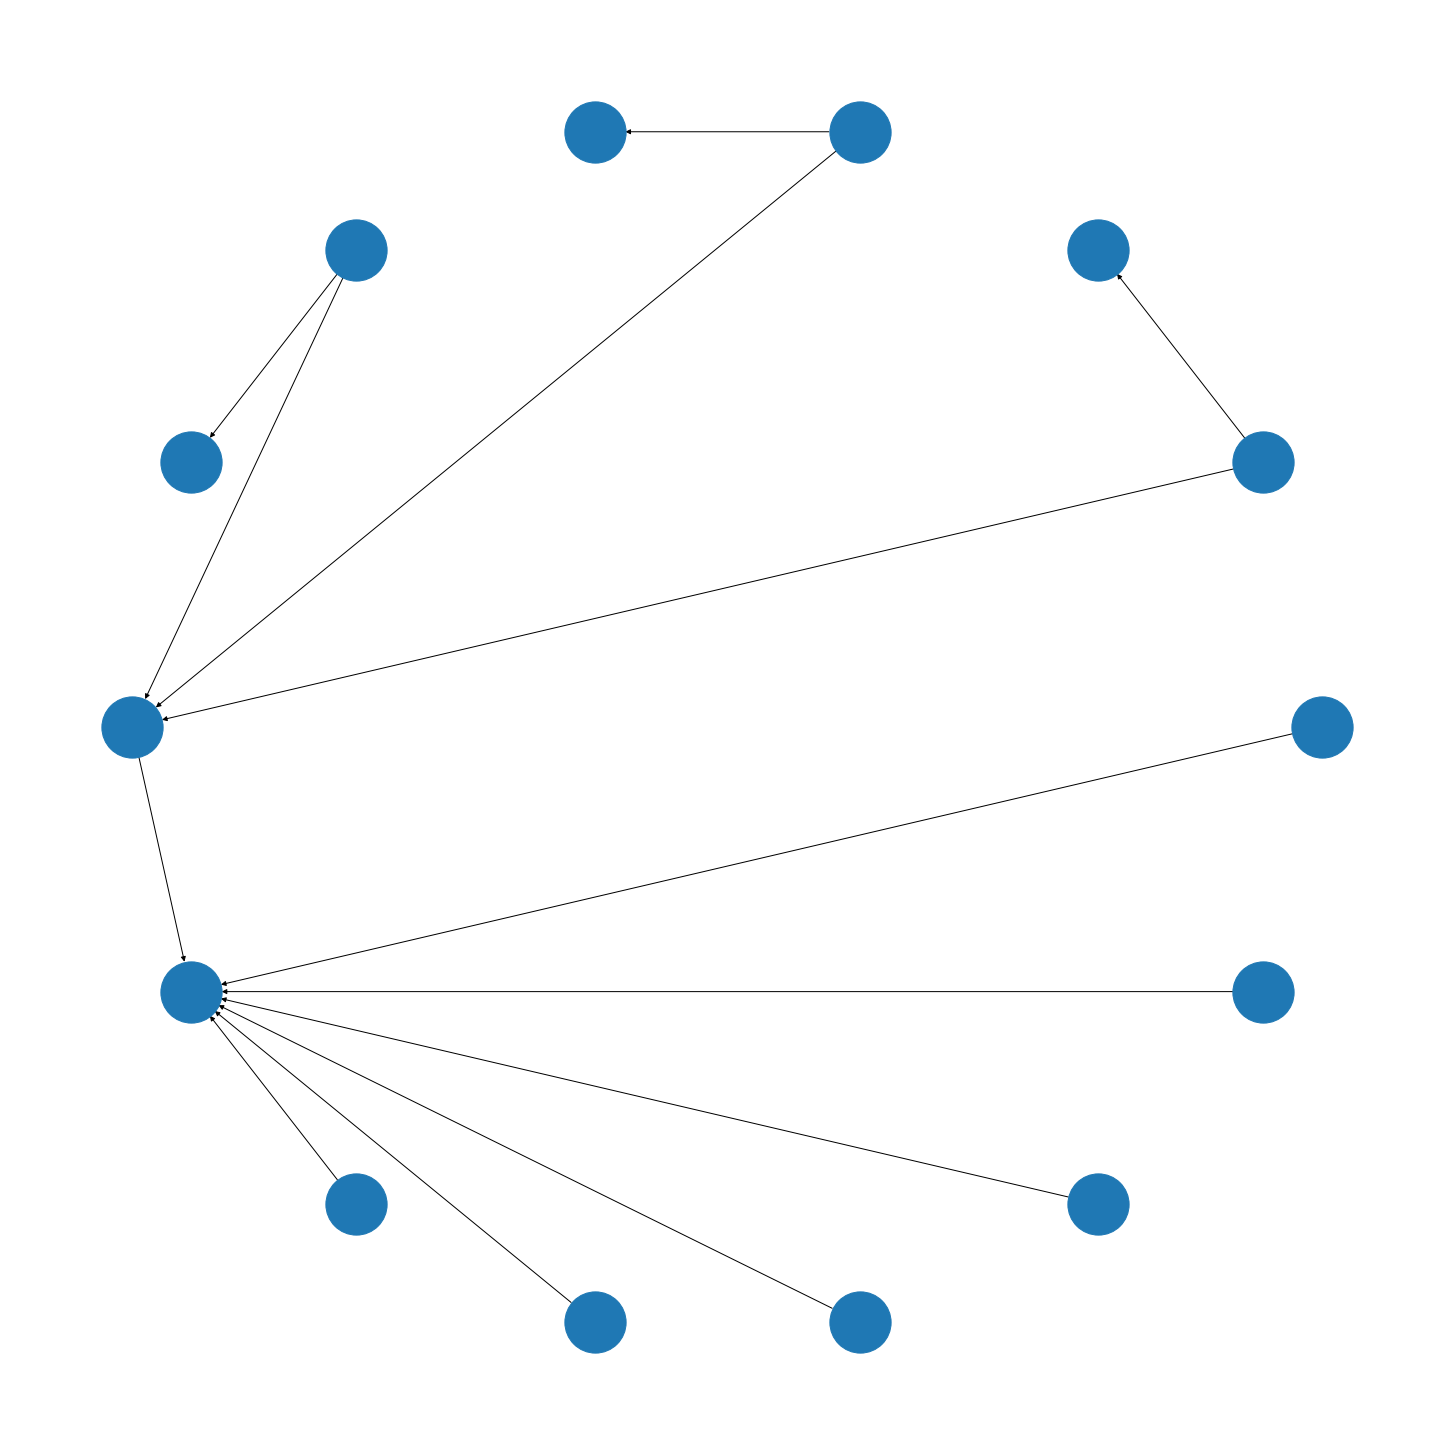

In [213]:
res_edges,nx_graph=create_graph(addresses)

In [216]:
from pyvis import network as nt

net=nt.Network(notebook=True,  bgcolor='#222222', font_color='white', width='100%', height='750px')
net.show_buttons(filter_=['physics'])
net.from_nx(nx_graph)
net.show('net.html')